# BrowserUnit Experimentation Notebook

Currently in-development **BrowserUnit** is a simple python library class for running Selenium Webdriver tests inside UnitTest functions. It is intended to speed the automation of simple and repetitive browser actions.

This notebook is a collection of experimental methods to develop a minimal set of functions for quickly checking for element content, element presence, switching pages, parsing sitemaps, etc.

**Conclusions** at bottom of document.


In [1]:
import rcf_lib as R
import unittest
import os
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options as C_Options
from selenium.webdriver.firefox.options import Options as FF_Options
import time
import sys
from colorama import init as cinit
cinit() # Filters ANSI escape sequences and inserts Win32 calls.

In [2]:
x = "Hello, world!"

In [3]:
print(x)

Hello, world!


In [4]:
# Assuming notebook was opened from py/
if( os.name == 'nt' ):
    print("Grabbing WinDOS executables...")
    FF_BINARY_PATH = "webdrivers/geckodriver.exe"
    CHROME_BINARY_PATH = "webdrivers/chromedriver.exe"
else:
    print("Grabbing Unix binaries...")
    FF_BINARY_PATH = "webdrivers/geckodriver"
    CHROME_BINARY_PATH = "webdrivers/chromedriver"
    
# In the future, throw errors if os.path to webdrivers folder/ drivers are not available.

def FF_DRIVER():
    firefox_options = FF_Options()
    return webdriver.Firefox(executable_path=FF_BINARY_PATH,options=firefox_options)

def C_DRIVER():
    chrome_options = C_Options()
    chrome_options.add_argument("--window-size=200,")
    chrome_options.add_argument("disable-infobars")
    chrome_options.add_argument("--disable-notifications")
    return webdriver.Chrome(executable_path=CHROME_BINARY_PATH,options=chrome_options)

# In final implementation, instantiate these drivers in test objects with bottlers (see #Implementation Plan)

Grabbing WinDOS executables...


At this point, `FF_DRIVER()` will open a FireFox window for testing, and `CHROME_DRIVER()` will open a Chrome window for testing. Both functions return the **driver** that is used for maniuplating the page. We'll attempt to open and manipulate the FireFox driver first. A window should open after this command is run.

In [5]:
# Test ChromeDriver
c_driver = C_DRIVER()
c_driver.get("http://catb.org/jargon/html/index.html")
print("Jargon" in c_driver.title) # Will print "True" if page loads successfully.
print(c_driver.title)
c_driver.close()

True
The Jargon File


In [6]:
# Test GeckoDriver
ff_driver = FF_DRIVER()
ff_driver.get("http://catb.org/jargon/html/index.html")
print("Jargon" in ff_driver.title) # Will print "True" if page loads successfully.
print(ff_driver.title)
ff_driver.close()

True
The Jargon File


### Requirements for the BrowserUnit Class:

1. Provide an abstraction layer for easy testing of website components.
2. Provide a system for defining the composition of a website's html so components can be isolated and verified as present or with certain properties.
3. Provide methods to check for elements and text on the page, in such a way that a script can be quickly constructed for testing against a requirement.
4. Provide a framework to write test cases for each requirement defined in a separate document of test cases.

### Stretch Functionality:

1. Pull and process sitemap using beautifulsoup , requests.

# Implementation Plan

In order to execute a series of pre-determined functions in order with variables, I will add the functions to a queue and execute them synchronously. I don't necessarily want to implement threading yet, but if I implement this correctly, it shouldn't be hard.

In [7]:
class Bottler:
    """Attempt to execute a stored array of functions."""
    def __init__(self):
        self.bottlingQueue = []

    def addTest(self, printme):
        def bottledTest():
            print( printme )
        self.bottlingQueue.append(bottledTest)

    def executeTests(self):
        for test in self.bottlingQueue:
            test()

b = Bottler()
b.addTest("One")
b.addTest("Two")
b.addTest("Three")
b.executeTests()

One
Two
Three


In [10]:
b.addTest("Four")
b.executeTests()

One
Two
Three
Four


`Bottler` demonstrates that functions can be stored as objects, stored in an array and called sequentially.

In [8]:
def initDriver( browser ):
    
    print(C_DRIVER)
    print(FF_DRIVER)
    
    if(str(browser).lower() =="chr"):
        return C_DRIVER
    elif(str(browser).lower() =="fir"):
        return FF_DRIVER

# Required Global Variables?
DRIVER = FF_DRIVER # initDriver("firefox") # Not sure why initDriver isn't functional.
DEBUG = True
UNITTESTS = []

# Eventually move to array of BrowserUnits
class UnitTestAtom(unittest.TestCase):
    
    def setUp(self):
        self.driver = DRIVER()
        self.a = "Lol"
        print("Setup")
        print(self)
    
    def tearDown(self):
        self.driver.close()
    
    def test_000_is_this_working(self):
        self.assertTrue( 1 > 0.9 )
    
    def ok(self):
        print("UnitTestAtom Instantiated.")

def BuildUnitTestAtom( name ):
    TestAtom = type(name, (UnitTestAtom,),{})
    return TestAtom() #Ensure the active class name is returned.

```
class BrowserUnitQueue(unittest.TestLoader):
    """Used for storing and running a collection of tests. One queue per Feature."""
    def __init__(self):
        self.test_queue = []
    
    def add_unit(self, x):
        self.test_queue.append(x)
    
    def list_units(self):
        print("")
        for x in self.test_queue:
            print(str(x))
```

In [9]:
class BrowserUnit():
    """Used for building a single unit-test."""
    def __init__(self, testname):
        self.testcase = BuildUnitTestAtom(str(testname))
        self.testcase.ok()
        self.test_number_int = 0
        # self.execute()
        self.functionQueue = []
        UNITTESTS.append(self)
    
    def assertTitle(self, string):
        
        def bottledAssertTitle(self):
            self.ok()
            print(self.a)
            self.assertIn(string, self.driver.title)
            self.assertTrue( 1>2 )
            
        setattr(self.cases(), 'test_{0}_title_{1}'.format(self.test_number(),string), bottledAssertTitle)
        
    def cases(self):
        """Returns the completed testcase class for inclusion in a suite."""
        return self.testcase.__class__
    
    def test_number(self):
        self.test_number_int += 1
        return str(self.test_number_int)
        
    def execute(self):
        """Do not use."""
        # unittest.TestSuite(tests=(self.testcase)).run()
        suite = unittest.TestLoader().loadTestsFromTestCase(self.testcase.__class__)
        unittest.TextTestRunner(verbosity=2).run(suite)

Basic tests for **BrowserUnit**:

In [11]:
test1 = BrowserUnit("test_one")
test1.assertTitle("nothing")
test1.execute()

UnitTestAtom Instantiated.


test_000_is_this_working (__main__.test_one) ... 

Setup
test_000_is_this_working (__main__.test_one)


ok
test_1_title_nothing (__main__.test_one) ... 

Setup
test_1_title_nothing (__main__.test_one)
UnitTestAtom Instantiated.
Lol


FAIL

FAIL: test_1_title_nothing (__main__.test_one)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-9-46ccb767e686>", line 16, in bottledAssertTitle
    self.assertIn(string, self.driver.title)
AssertionError: 'nothing' not found in ''

----------------------------------------------------------------------
Ran 2 tests in 13.679s

FAILED (failures=1)


Now that we can store a unittest in BrowserUnit, let's see if we can run a few BrowserUnits with their internal TestAtoms:

In [12]:
UNITTESTS = [] # Clear previous unittests.

test1 = BrowserUnit("test_one")
test2 = BrowserUnit("test_two")
test3 = BrowserUnit("test_three")

SUITES = []
# suite = unittest.TestLoader().loadTestsFromTestCase(self.testcase.__class__)
# unittest.TextTestRunner(verbosity=2).run(suite)

# Combine test suites.
for x in UNITTESTS:
    suite = unittest.TestLoader().loadTestsFromTestCase(x.cases())
    SUITES.append(suite)

FINAL_SUITE = unittest.TestSuite(SUITES)
runner = unittest.TextTestRunner()
print(runner.run(FINAL_SUITE))

UnitTestAtom Instantiated.
UnitTestAtom Instantiated.
UnitTestAtom Instantiated.
Setup
test_000_is_this_working (__main__.test_one)


.

Setup
test_000_is_this_working (__main__.test_two)


.

Setup
test_000_is_this_working (__main__.test_three)


.
----------------------------------------------------------------------
Ran 3 tests in 20.722s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>


In [13]:
x = print
x("lol") # Oh, damn. Functions are objects.

# BROWSER_UNIT_QUEUE = BrowserUnitQueue()
# BROWSER_UNIT_QUEUE.add_unit("This ought to be a unittest obj.")
# BROWSER_UNIT_QUEUE.list_units()

lol


Populating the interactive namespace from numpy and matplotlib


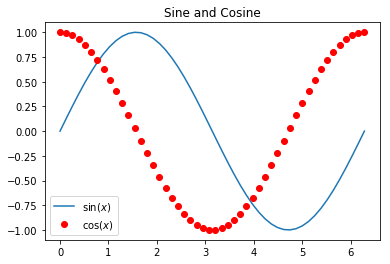

In [14]:
%pylab inline
x = linspace(0, 2*pi)
plot(x, sin(x), label=r'$\sin(x)$')
plot(x, cos(x), 'ro', label=r'$\cos(x)$')
title(r'Sine and Cosine')
legend() # Wow, this graph is pretty magical.




# Conclusions

I could continue to take this experiment in one of two ways:
1. Define a test, actionqueue and createstep methods in BrowserUnit so instantiating a browserunit for each test area is correct.
2. Define a variety of actions in BrowserUnit and stack a bunch of BrowserUnits in a larger BrowserUnitArea class.


